In [2]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2.2.3


In [21]:
Guatemala_Data = '1JywFwg0TLswsumYX932nagHF1rgsvvzeIUXZwhmzJ6s'

In [23]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Guatemala_Data' to key of your own sheet in Sheets, above
x = read_sheets(Guatemala_Data,sheet='Food Expenditures (2000)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Guatemala_Data,sheet='Food Prices (2000)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(Guatemala_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

In [24]:
d.head()

,,k,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99
i,t,m,,,,,,,,,,,,,,
1,2000,Metropolitana,0,1,0,0,0,0,0,0,1,1,0,1,0,0
2,2000,Metropolitana,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,2000,Metropolitana,0,0,0,0,2,0,0,0,1,0,1,1,1,0
4,2000,Metropolitana,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,2000,Metropolitana,0,0,1,0,0,0,0,0,0,0,1,1,0,0


In [25]:
y.head()

i  t     m              j             
1  2000  Metropolitana  Avocado           1.609438
                        Bananas           2.639057
                        Beans             1.609438
                        Beef              5.828946
                        Bread (french)    3.401197
Name: Expenditure, dtype: float64

In [26]:
from cfe import Regression

result = Regression(y=y,d=d)

In [27]:
result.predicted_expenditures()

i     t     m              j             
1     2000  Metropolitana  Avocado             7.088698
                           Bananas            16.067197
                           Beans               9.494430
                           Beef              100.138098
                           Beef Entrails      13.948086
                                                ...    
7276  2000  Suroriente     Tostadas            9.664286
                           Water (bottle)     11.366774
                           Watermelon          7.872758
                           Wheat Flour         4.710398
                           Yucca               3.394201
Length: 515736, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

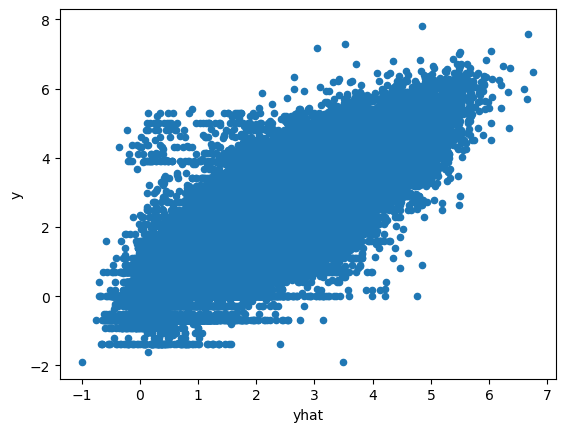

In [28]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

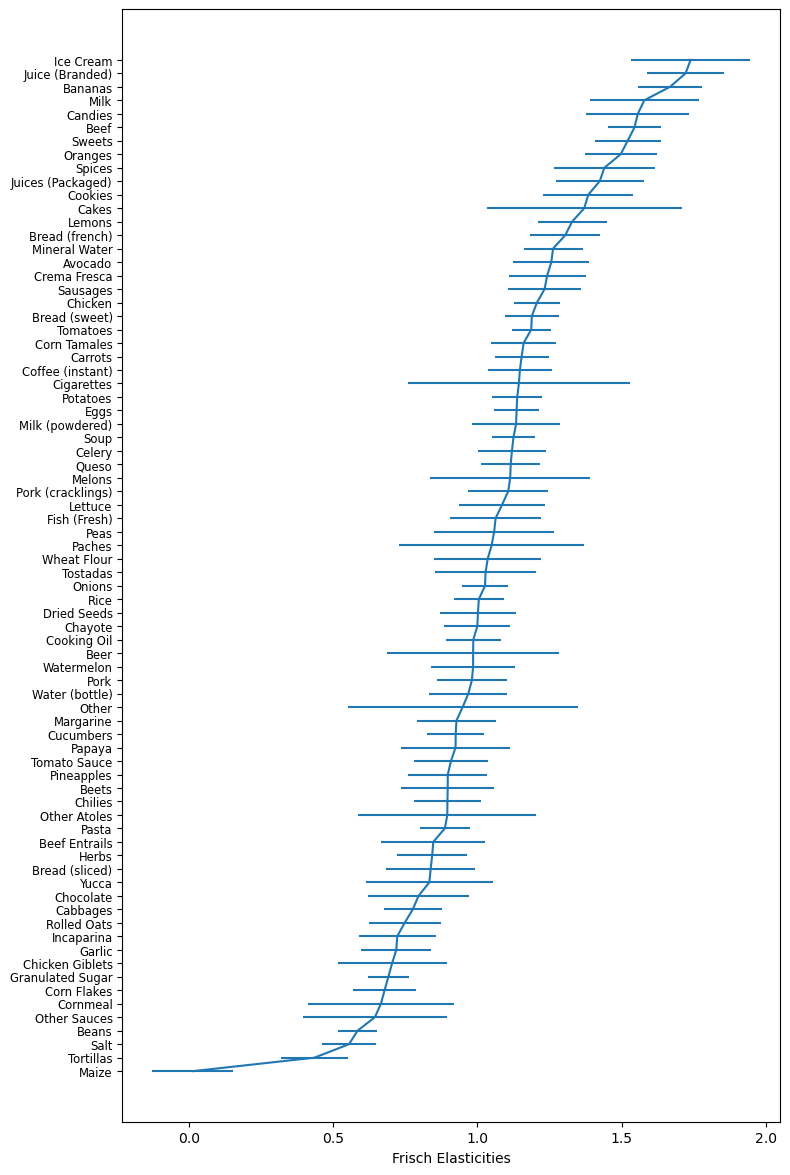

In [29]:
ax = result.graph_beta()

In [30]:
result.get_beta()

j
Avocado           1.256097
Bananas           1.667667
Beans             0.584281
Beef              1.544521
Beef Entrails     0.846793
                    ...   
Tostadas          1.028208
Water (bottle)    0.968440
Watermelon        0.984878
Wheat Flour       1.035524
Yucca             0.833105
Name: beta, Length: 76, dtype: float64

In [31]:
result.get_gamma()

k,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,Constant
j,,,,,,,,,,,,,,,
Avocado,-0.088275,-0.122866,-0.027481,-0.049743,-0.011544,-0.028603,0.027512,0.000261,0.074529,0.161430,0.158562,0.298749,0.062668,0.063345,1.749162
Bananas,-0.115450,-0.145996,-0.055901,-0.048553,-0.030538,-0.031087,0.020161,0.029274,0.102862,0.200082,0.145734,0.281083,-0.011023,0.132700,2.601493
Beans,0.084385,0.060966,0.117293,0.090192,0.149595,0.105575,0.223101,0.136226,0.151246,0.094017,0.155123,0.098994,0.194210,0.128332,2.569973
Beef,-0.137689,-0.105542,-0.045396,-0.034741,-0.001552,-0.011293,0.048299,0.052845,0.159855,0.250684,0.237983,0.286949,0.059454,0.062816,4.194728
Beef Entrails,0.029093,-0.043311,-0.049139,0.016524,0.048557,0.067730,0.018645,0.094059,0.023180,0.163656,0.100741,0.096734,0.027478,0.029255,2.603261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tostadas,-0.104827,0.018316,-0.005392,0.065595,0.131417,0.026776,0.139571,0.060413,0.036817,0.108625,0.102481,0.105183,-0.017120,0.048025,2.129704
Water (bottle),-0.015467,-0.028098,-0.010616,-0.027088,-0.101461,-0.020004,-0.031444,0.001428,0.060548,0.050409,0.129648,0.256980,0.022353,0.138386,2.741034
Watermelon,0.024007,-0.021794,0.025018,-0.042928,-0.005028,0.076032,0.022955,0.081937,0.061462,0.124539,0.066374,0.153493,-0.003809,-0.024234,1.949779


<Axes: ylabel='Density'>

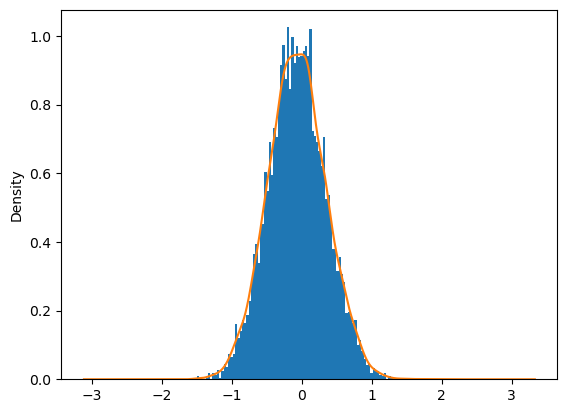

In [32]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [34]:
result.to_pickle('guatemala_estimates.rgsn')

In [35]:
import cfe
result = cfe.regression.read_pickle('guatemala_estimates.rgsn')

In [36]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [37]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

Text(0.5, 0, 'Quantities of Maize Demanded')

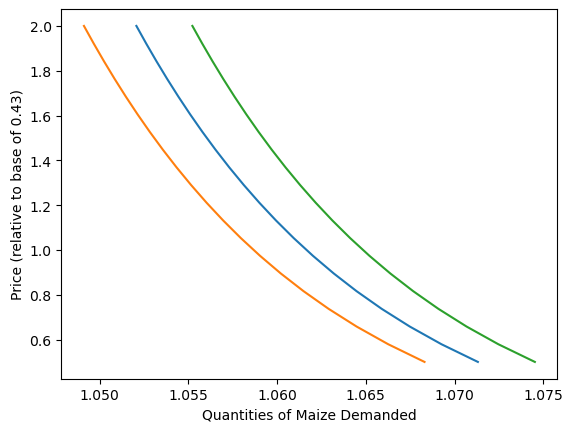

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Maize'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 1.0, 'Engel Curves')

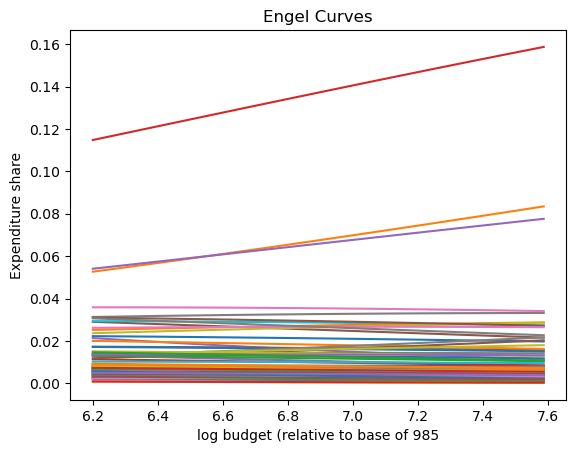

In [39]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

Text(0.5, 1.0, 'Indirect Utility Function')

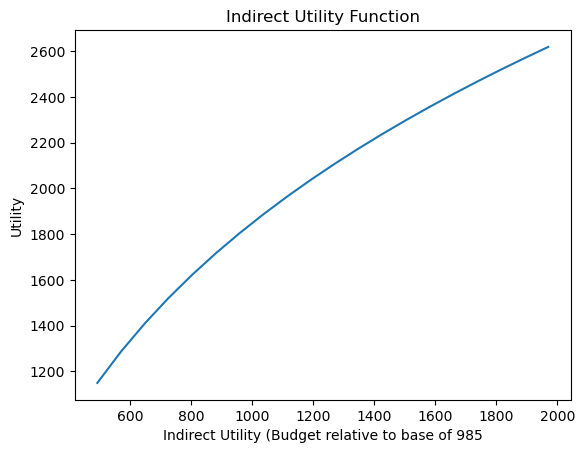

In [40]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')